<a href="https://colab.research.google.com/github/rich-hyun/Kuggle_9th_team_SAMTARBUCKS/blob/main/Samtarbucks_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. 데이터 가져오기



In [ ]:
!pip install transformers
!pip install wordcloud
!pip install pandas textblob
!pip install nltk
!pip install pyLDAvis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#사용할 코드 import 하기
import os
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from transformers import pipeline
from datetime import datetime
from calendar import calendar
from textblob import TextBlob
from calendar import month_name
import calendar
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import GridSearchCV
from wordcloud import WordCloud
from matplotlib.pyplot import subplots
from matplotlib.pyplot import axis
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from plotly.express import bar
from collections import Counter
import pyLDAvis
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import mean_squared_error
import numpy as np

nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# 데이터 로딩
df = pd.read_csv('https://raw.githubusercontent.com/rich-hyun/Kuggle_9th_team_/main/reviews_data.csv', encoding='utf-8')

# 'Date' 열에서 월, 일, 연도 추출
df['mnth'] = df['Date'].str.extract(r'Reviewed\s+([A-Za-z]+)')
df['day'] = df['Date'].str.extract(r'(\d{1,2}),').astype(int)
df['year'] = df['Date'].str.extract(r'(\d{4})').astype(int)

# 월 이름을 숫자로 매핑
months_map = {
    'Jan': 1, 'Feb': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'Aug': 8, 'Sept': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
df['mnth_num'] = df['mnth'].map(months_map)

# 월 번호로 변환
month_mapping = {v: k for k,v in enumerate(calendar.month_name)}
df['month_num'] = df['mnth'].map(month_mapping)

# 요일 계산
df['day2'] = df.apply(lambda row: datetime.strptime(f"{row['year']}-{row['mnth_num']}-{row['day']}", '%Y-%m-%d').strftime('%A'), axis=1)

# 요일 숫자로 매핑
day_to_num = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
    'Friday': 4, 'Saturday': 5, 'Sunday': 6
}
df['day2_num'] = df['day2'].map(day_to_num)

# 필요한 열만 선택
df = df[['name', 'location', 'Date', 'year', 'mnth_num', 'day', 'day2_num', 'Rating', 'Review']]

# 'Rating'이 NaN인 행만 df_no_rating에 저장합니다.
df_no_rating = df[df['Rating'].isna()]
df_no_rating.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,name,location,Date,year,mnth_num,day,day2_num,Rating,Review
700,James,"Kansas City, MO","Reviewed July 25, 2011",2011,7,25,0,NaN,I just wanted to amend my email the I sent to ...
701,James,"Kansas City, MO","Reviewed July 25, 2011",2011,7,25,0,NaN,"Recently, I have gone to your Starbucks at Bar..."
702,Mike,"Revere, ma","Reviewed June 26, 2011",2011,6,26,6,NaN,Upon my first visit to this location on my way...
703,Hughes,"Macclesfield, Other","Reviewed Jan. 13, 2011",2011,1,13,3,NaN,"Recently, British Royal Marines in Iraq wrote ..."
704,Sherrilynn,"Jenison, MI","Reviewed Jan. 4, 2011",2011,1,4,1,NaN,"On the way to catch our plane, we got a medium..."


In [ ]:
# NaN이 있는 행 제거
df.dropna(subset=['Rating', 'Review'], inplace = True)

# 결과 확인
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-5-228459276db1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['Rating', 'Review'], inplace = True)


,name,location,Date,year,mnth_num,day,day2_num,Rating,Review
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",2023,9,13,2,5.0,Amber and LaDonna at the Starbucks on Southwes...
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",2023,7,16,6,5.0,** at the Starbucks by the fire station on 436...
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",2023,7,5,2,5.0,I just wanted to go out of my way to recognize...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",2023,5,26,4,5.0,Me and my friend were at Starbucks and my card...
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",2023,1,22,6,5.0,I?셫 on this kick of drinking 5 cups of warm wa...


In [ ]:
df.isna().sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


name        0
location    0
Date        0
year        0
mnth_num    0
day         0
day2_num    0
Rating      0
Review      0
dtype: int64

#2. "간단한" EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 701 entries, 0 to 745
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      701 non-null    object 
 1   location  701 non-null    object 
 2   Date      701 non-null    object 
 3   year      701 non-null    int64  
 4   mnth_num  701 non-null    int64  
 5   day       701 non-null    int64  
 6   day2_num  701 non-null    int64  
 7   Rating    701 non-null    float64
 8   Review    701 non-null    object 
dtypes: float64(1), int64(4), object(4)
memory usage: 54.8+ KB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


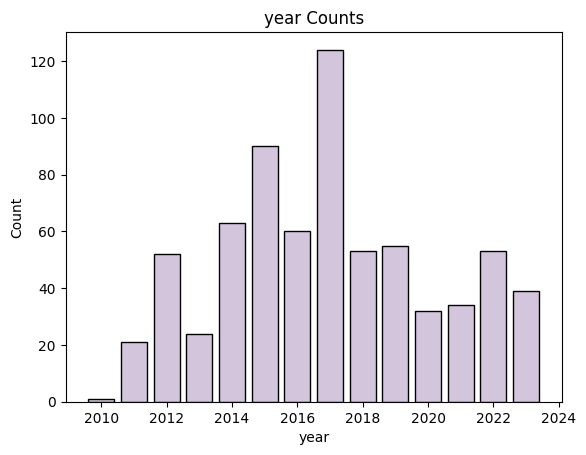

In [ ]:
rating_counts = df['year'].value_counts()

plt.bar(rating_counts.index, rating_counts.values, color='#D3C6DC', edgecolor='black')

plt.title('year Counts')
plt.xlabel('year')
plt.ylabel('Count')

plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


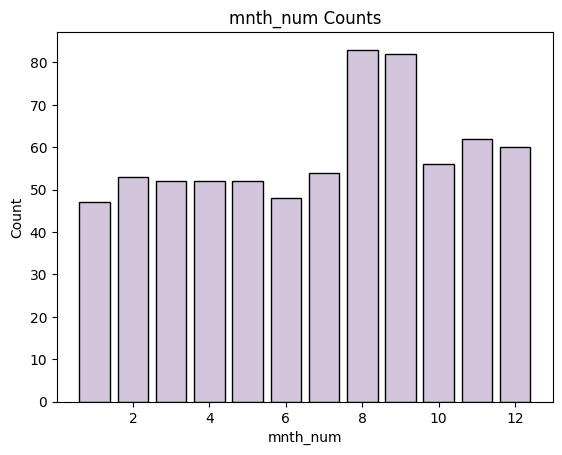

In [ ]:
rating_counts = df['mnth_num'].value_counts()

plt.bar(rating_counts.index, rating_counts.values, color='#D3C6DC', edgecolor='black')

plt.title('mnth_num Counts')
plt.xlabel('mnth_num')
plt.ylabel('Count')

plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


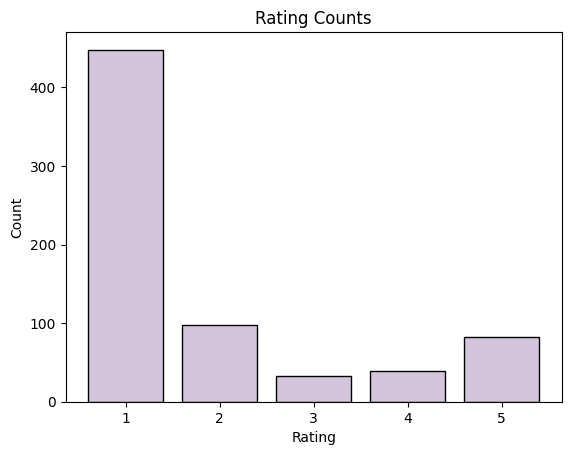

In [ ]:
rating_counts = df['Rating'].value_counts()

plt.bar(rating_counts.index, rating_counts.values, color='#D3C6DC', edgecolor='black')

plt.title('Rating Counts')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


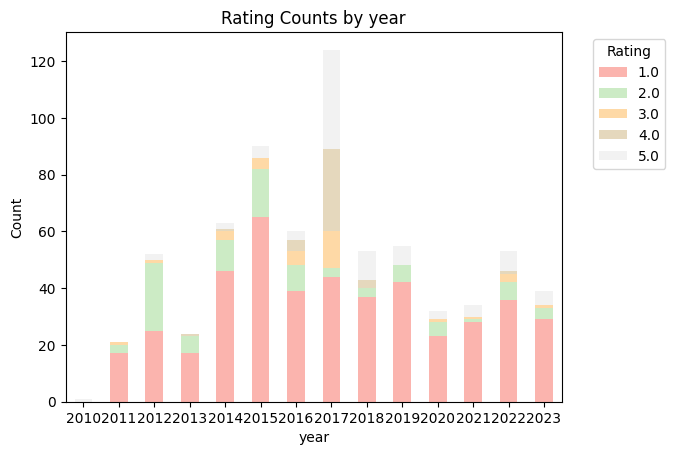

In [ ]:
## year에 따른 Rating 분포 확인

rating_counts_by_year = df.groupby('year')['Rating'].value_counts().unstack(fill_value=0)

rating_counts_by_year.plot(kind='bar', stacked=True, colormap='Pastel1')

plt.title('Rating Counts by year')
plt.xlabel('year')
plt.ylabel('Count')

plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)

plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


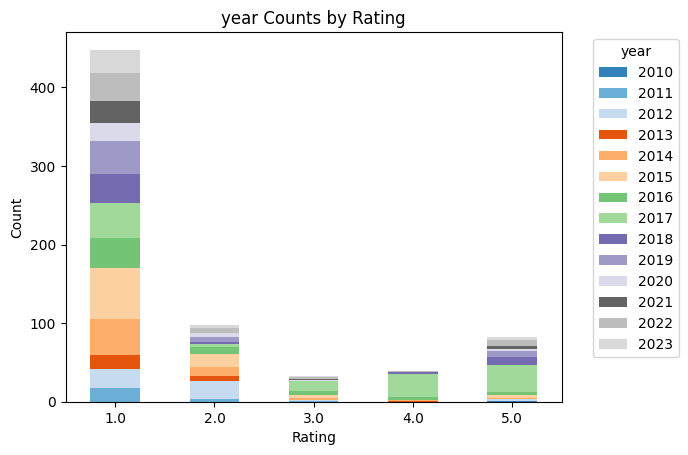

In [ ]:
## 각각의 Rating에 따른 year 분포 확인

rating_counts_by_year = df.groupby('Rating')['year'].value_counts().unstack(fill_value=0)

ax = rating_counts_by_year.plot(kind='bar', stacked=True, colormap='tab20c')

plt.title('year Counts by Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.legend(title='year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)

plt.show()

## 높은 Rating(4,5)의 경우 2017년의 비중이 매우 높은 것으로 확인

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


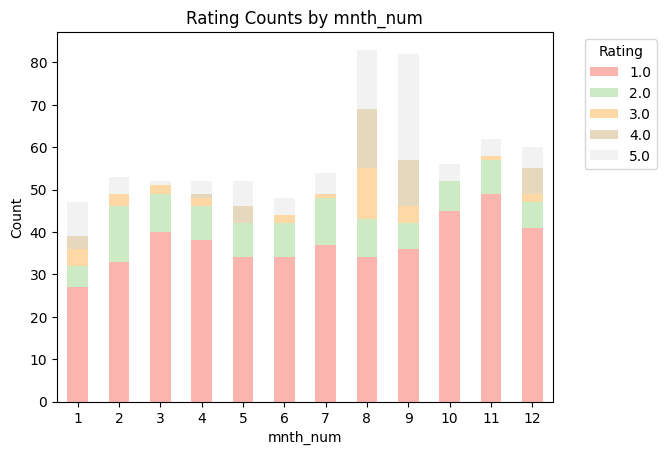

In [ ]:
## mnth_num에 따른 Rating 분포 확인

rating_counts_by_month = df.groupby('mnth_num')['Rating'].value_counts().unstack(fill_value=0)

rating_counts_by_month.plot(kind='bar', stacked=True, colormap='Pastel1')

plt.title('Rating Counts by mnth_num')
plt.xlabel('mnth_num')
plt.ylabel('Count')

plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)

plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


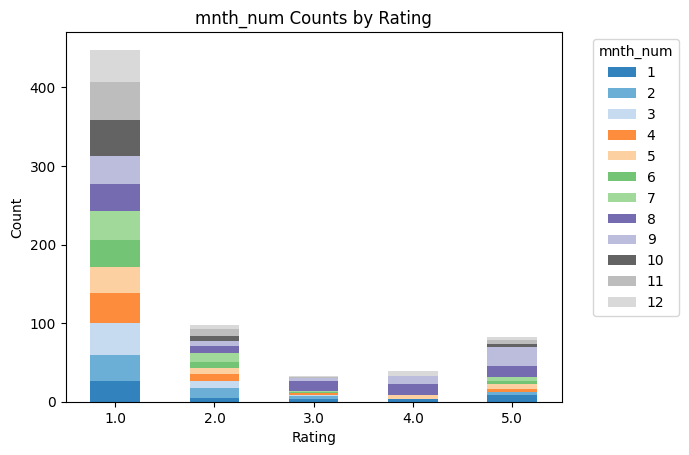

In [ ]:
## 각각의 Rating에 따른 mnth_num 분포 확인

rating_counts_by_month = df.groupby('Rating')['mnth_num'].value_counts().unstack(fill_value=0)

ax = rating_counts_by_month.plot(kind='bar', stacked=True, colormap='tab20c')

plt.title('mnth_num Counts by Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.legend(title='mnth_num', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)

plt.show()

## Rating=1,2인 경우 mnth_num별 비중이 비슷하지만 Rating=3,4,5인 경우 mnth_num=8,9의 비중이 높은 걸 확인할 수 있음

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


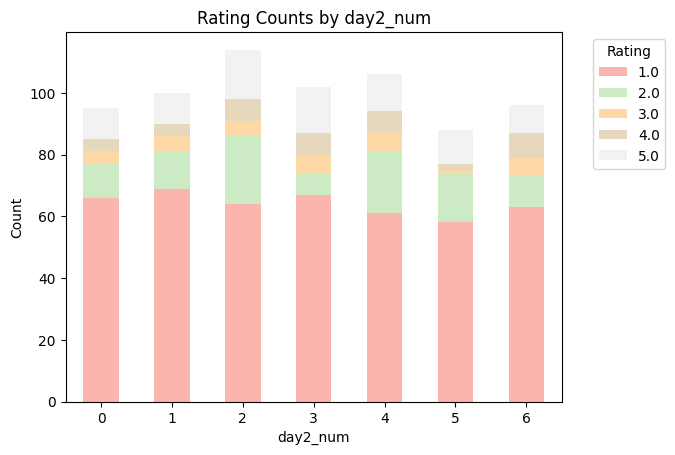

In [ ]:
## day2_num에 따른 Rating 분포 확인

rating_counts_by_day = df.groupby('day2_num')['Rating'].value_counts().unstack(fill_value=0)

rating_counts_by_day.plot(kind='bar', stacked=True, colormap='Pastel1')

plt.title('Rating Counts by day2_num')
plt.xlabel('day2_num')
plt.ylabel('Count')

plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)

plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


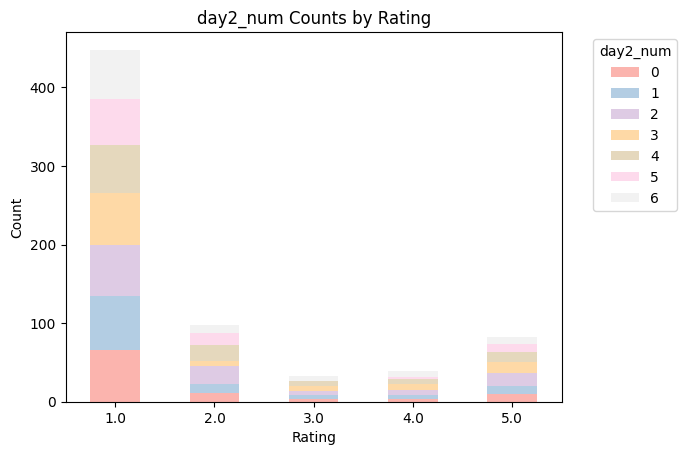

In [ ]:
## 각각의 Rating에 따른 day2_num 분포 확인

rating_counts_by_day = df.groupby('Rating')['day2_num'].value_counts().unstack(fill_value=0)

ax = rating_counts_by_day.plot(kind='bar', stacked=True, colormap='Pastel1')

plt.title('day2_num Counts by Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.legend(title='day2_num', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)

plt.show()

## 어느 특정 요일에 어떤 Rating 값이 늘어난다거나 줄어드다는 등의 관계는 없는 것으로 확인

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


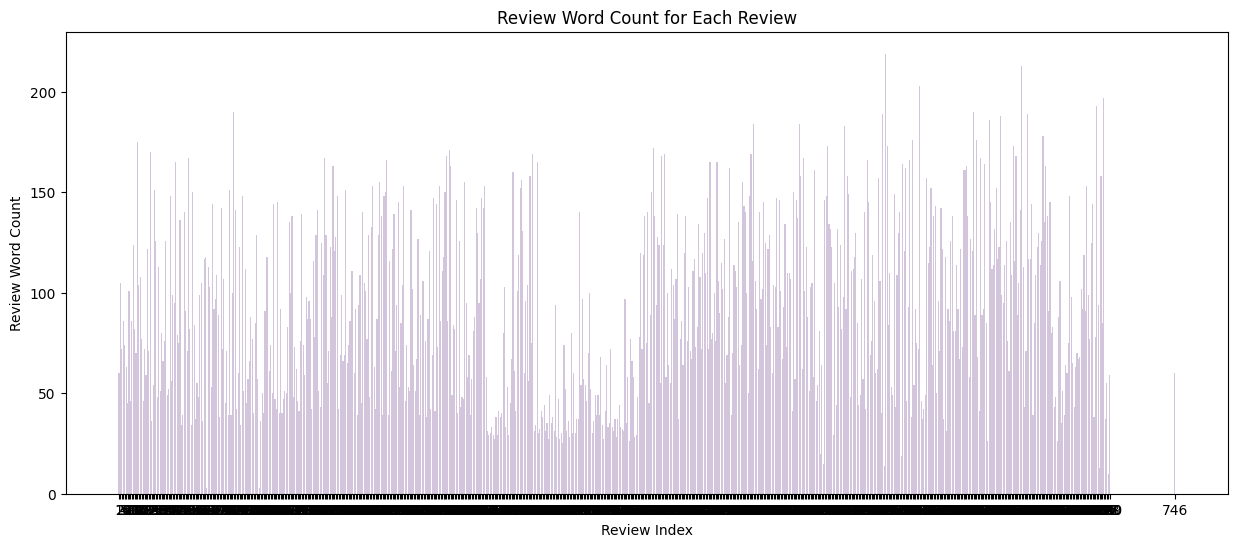

In [ ]:
df['Review_Word_Count'] = df['Review'].apply(lambda x: len(x.split()))

plt.figure(figsize=(15, 6))
plt.bar(df.index, df['Review_Word_Count'], color='#D3C6DC')

plt.title('Review Word Count for Each Review')
plt.xlabel('Review Index')
plt.ylabel('Review Word Count')

plt.xticks(df.index, [f'{i+1}' for i in df.index])

plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


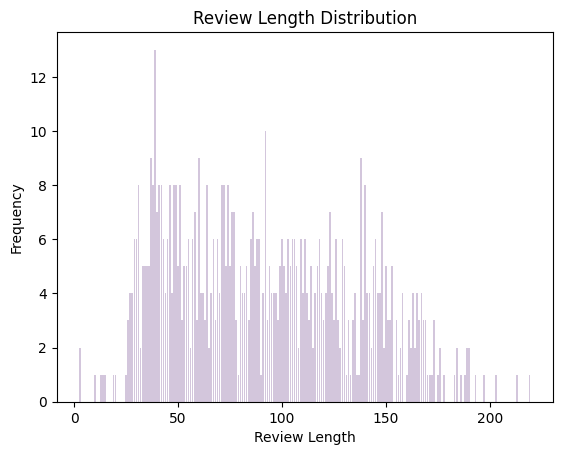

In [ ]:
def plot_review_length_distribution(texts):
    review_lengths = [len(sentence.split()) for sentence in texts]
    length_counts = Counter(review_lengths)

    plt.bar(length_counts.keys(), length_counts.values(), color='#D3C6DC')
    plt.title('Review Length Distribution')
    plt.xlabel('Review Length')
    plt.ylabel('Frequency')
    plt.show()

plot_review_length_distribution(df['Review'])

In [ ]:
bar(data_frame=df['name'].value_counts().to_frame())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# 맨뒤 알파벳 두글자로 지역
new_loc= df['location'].str[-2:]
#소문자는 else로 취급
new_loc = new_loc.apply(lambda x: x if x.isupper() else 'else')

#CA 가 매우 많음
bar(data_frame=new_loc.value_counts().to_frame())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



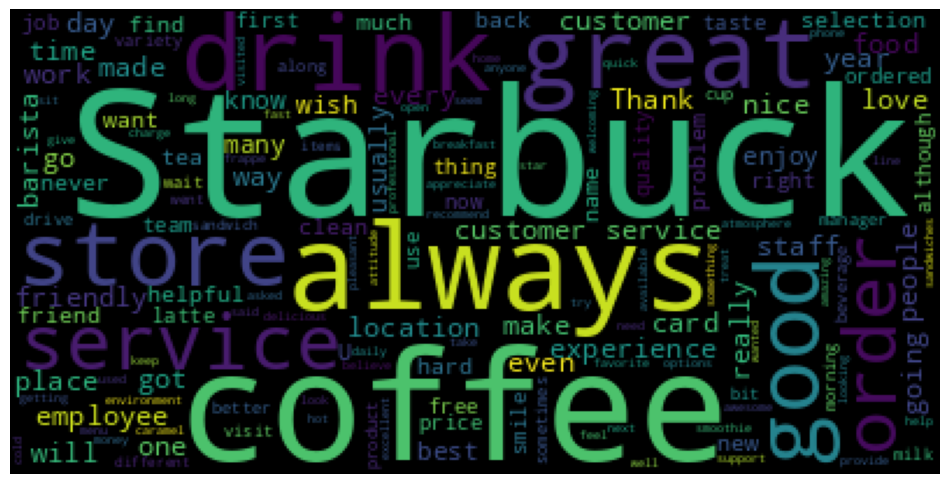

In [ ]:
subplots(figsize=(12, 12))
axis('off')
imshow(WordCloud(random_state=2023).generate(' '.join(df[df['Rating'] > 3]['Review'].values.tolist())))

#3. 리뷰 감정에 따라 분석

##textblob 방식

In [ ]:
# NLTK 리소스 다운로드 (불용어, 토크나이저)
nltk.download('punkt')
nltk.download('stopwords')
df_cleaned=df_no_rating
# 텍스트 정규화: 소문자 변환
df_cleaned['Review'] = df_cleaned['Review'].str.lower()

# 토큰화: 각 리뷰를 개별 단어로 분리
df_cleaned['tokens'] = df_cleaned['Review'].apply(word_tokenize)

# 불용어 리스트 로드
stop_words = set(stopwords.words('english'))

# 불용어 제거
df_cleaned['tokens'] = df_cleaned['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# 어간 추출기 초기화
stemmer = SnowballStemmer('english')

# 어간 추출
df_cleaned['stemmed'] = df_cleaned['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])

# 결과 확인
df_cleaned[['Review', 'tokens', 'stemmed']].head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-22-8bac29ff2efe>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-22-8bac29ff2efe>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a 

,Review,tokens,stemmed
700,i just wanted to amend my email the i sent to ...,"[wanted, amend, email, sent, hour, ago, rude, ...","[want, amend, email, sent, hour, ago, rude, ob..."
701,"recently, i have gone to your starbucks at bar...","[recently, ,, gone, starbucks, barry, rd, ., k...","[recent, ,, gone, starbuck, barri, rd, ., kans..."
702,upon my first visit to this location on my way...,"[upon, first, visit, location, way, work, ,, w...","[upon, first, visit, locat, way, work, ,, went..."
703,"recently, british royal marines in iraq wrote ...","[recently, ,, british, royal, marines, iraq, w...","[recent, ,, british, royal, marin, iraq, wrote..."
704,"on the way to catch our plane, we got a medium...","[way, catch, plane, ,, got, medium, coffee, &,...","[way, catch, plane, ,, got, medium, coffe, &, ..."


In [ ]:
# 감정 및 주관성 분석을 위한 함수 정의
def analyze_sentiment(text):
    # TextBlob 객체 생성
    analysis = TextBlob(text)
    # 감정(polarity)과 주관성(subjectivity) 반환
    return analysis.sentiment

# 'Review' 컬럼에 대해 감정 및 주관성 분석 수행
df_cleaned['sentiment'] = df_cleaned['Review'].apply(lambda x: analyze_sentiment(x))

# 결과 확인
df_cleaned[['Review', 'sentiment']].head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-23-e674922a9842>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Review,sentiment
700,i just wanted to amend my email the i sent to ...,"(-0.375, 0.6)"
701,"recently, i have gone to your starbucks at bar...","(0.17142857142857143, 0.46297619047619054)"
702,upon my first visit to this location on my way...,"(-0.010937499999999975, 0.46249999999999997)"
703,"recently, british royal marines in iraq wrote ...","(0.31666666666666665, 0.3333333333333333)"
704,"on the way to catch our plane, we got a medium...","(0.17083333333333334, 0.5791666666666667)"


In [ ]:
# TextBlob을 사용하여 감정(polarity)과 주관성(subjectivity) 점수 계산
df_cleaned['Polarity'] = df_cleaned['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_cleaned['Subjectivity'] = df_cleaned['Review'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# 감정 점수를 기반으로 레이블 생성
df_cleaned['Label'] = df_cleaned['Polarity'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

# 레이블 생성
def label_sentiment(row):
    if row['Polarity'] > 0:
        return 'positive'
    elif row['Polarity'] < 0:
        return 'negative'
    else:
        return 'neutral'

df_cleaned['Label'] = df_cleaned.apply(label_sentiment, axis=1)

label_counts = df_cleaned['Label'].value_counts()
label_counts

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-24-8f8864d79cb8>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-24-8f8864d79cb8>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-24-8f88

Label
positive    59
negative    47
neutral     39
Name: count, dtype: int64

In [ ]:
# 피처 엔지니어링 - TF-IDF
tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(df_cleaned['Review'])
y = df_cleaned['Label']

# 토큰화 및 패딩 - LSTM을 위한 준비
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df_cleaned['Review'])
X_seq = tokenizer.texts_to_sequences(df_cleaned['Review'])
X_pad = pad_sequences(X_seq, maxlen=100)

# 레이블 인코딩 - LSTM을 위한 준비
encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)

# 데이터 분할 - TF-IDF 기반 모델
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# 데이터 분할 - LSTM 모델
X_train_lstm, X_test_lstm, y_train_enc, y_test_enc = train_test_split(X_pad, y_enc, test_size=0.2, random_state=42)

# 모델 선택 및 훈련
models = {
    'Logistic Regression': LogisticRegression(),
    'Support Vector Machine': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'LightGBM': LGBMClassifier(verbose=-1)
}

# 각 모델에 대한 훈련 및 성능 평가 - TF-IDF 기반 모델
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    predictions = model.predict(X_test_tfidf)
    print(f"Model: {name}")
    print(classification_report(y_test, predictions))

# LSTM 모델 정의
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=5000, output_dim=100, input_length=100))
lstm_model.add(LSTM(units=128))
lstm_model.add(Dense(3, activation='softmax'))  # 3개의 출력 클래스

# LSTM 모델 컴파일
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# LSTM 모델 훈련
lstm_model.fit(X_train_lstm, y_train_enc, epochs=5, batch_size=64)

# LSTM 모델 성능 평가
loss, accuracy = lstm_model.evaluate(X_test_lstm, y_test_enc)
print(f'LSTM model accuracy: {accuracy}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/

Model: Logistic Regression
              precision    recall  f1-score   support

    negative       0.33      0.50      0.40         6
     neutral       1.00      1.00      1.00         8
    positive       0.75      0.60      0.67        15

    accuracy                           0.69        29
   macro avg       0.69      0.70      0.69        29
weighted avg       0.73      0.69      0.70        29

Model: Support Vector Machine
              precision    recall  f1-score   support

    negative       0.50      0.33      0.40         6
     neutral       1.00      1.00      1.00         8
    positive       0.76      0.87      0.81        15

    accuracy                           0.79        29
   macro avg       0.75      0.73      0.74        29
weighted avg       0.77      0.79      0.78        29

Model: Random Forest
              precision    recall  f1-score   support

    negative       0.31      0.67      0.42         6
     neutral       0.89      1.00      0.94        

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtyp

Model: Gradient Boosting
              precision    recall  f1-score   support

    negative       0.33      0.50      0.40         6
     neutral       1.00      1.00      1.00         8
    positive       0.75      0.60      0.67        15

    accuracy                           0.69        29
   macro avg       0.69      0.70      0.69        29
weighted avg       0.73      0.69      0.70        29

Model: LightGBM
              precision    recall  f1-score   support

    negative       0.30      0.50      0.37         6
     neutral       0.89      1.00      0.94         8
    positive       0.70      0.47      0.56        15

    accuracy                           0.62        29
   macro avg       0.63      0.66      0.63        29
weighted avg       0.67      0.62      0.63        29



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtyp

Epoch 1/5
2/2 [==============================] - 3s 179ms/step - loss: 1.0934 - accuracy: 0.4741
Epoch 2/5
2/2 [==============================] - 0s 195ms/step - loss: 1.0584 - accuracy: 0.7845
Epoch 3/5
2/2 [==============================] - 0s 264ms/step - loss: 1.0106 - accuracy: 0.8190
Epoch 4/5
2/2 [==============================] - 1s 264ms/step - loss: 0.9200 - accuracy: 0.8966
Epoch 5/5
1/1 [==============================] - 1s 1s/step - loss: 1.0754 - accuracy: 0.5517
LSTM model accuracy: 0.5517241358757019


In [ ]:
# 로지스틱 회귀 하이퍼파라미터 그리드
lr_params = {
    'C': [0.1, 1, 10],
    'max_iter': [100, 200]
}

# 서포트 벡터 머신 하이퍼파라미터 그리드
svc_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

# 랜덤 포레스트 하이퍼파라미터 그리드
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}

# 그래디언트 부스팅 하이퍼파라미터 그리드
gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10]
}

# LightGBM 하이퍼파라미터 그리드
lgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 62, 127],
    'boosting_type': ['gbdt', 'dart']
}

# 모델별 그리드 탐색 설정
model_params = {
    'Logistic Regression': (LogisticRegression(), lr_params),
    'Support Vector Machine': (SVC(), svc_params),
    'Random Forest': (RandomForestClassifier(), rf_params),
    'Gradient Boosting': (GradientBoostingClassifier(), gb_params),
    'LightGBM': (LGBMClassifier(verbose=-1), lgb_params)
}

# 각 모델에 대한 그리드 탐색 수행
for model_name, (model, params) in model_params.items():
    gs = GridSearchCV(model, params, cv=3, n_jobs=-1, verbose=1)
    gs.fit(X_train_tfidf, y_train)
    print(f"{model_name} best params: {gs.best_params_}")
    print(f"{model_name} best score: {gs.best_score_}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/

Logistic Regression best params: {'C': 1, 'max_iter': 100}
Logistic Regression best score: 0.6461988304093568
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtyp

Support Vector Machine best params: {'C': 1, 'kernel': 'linear'}
Support Vector Machine best score: 0.6635177687809267
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



Random Forest best params: {'max_depth': 30, 'n_estimators': 200}
Random Forest best score: 0.689833558254611
Fitting 3 folds for each of 27 candidates, totalling 81 fits


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtyp

Gradient Boosting best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Gradient Boosting best score: 0.7498875393612235
Fitting 3 folds for each of 54 candidates, totalling 162 fits


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtyp

LightGBM best params: {'boosting_type': 'dart', 'learning_rate': 0.01, 'n_estimators': 100, 'num_leaves': 31}
LightGBM best score: 0.672514619883041


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtyp

In [ ]:
# 피처 엔지니어링 - TF-IDF
tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(df_cleaned['Review'])
y = df_cleaned['Label']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# 최적의 하이퍼파라미터를 사용하여 모델 생성 및 훈련
logreg_model = LogisticRegression(C=1, max_iter=100)
logreg_model.fit(X_train, y_train)

svm_model = SVC(C=10, kernel='rbf')
svm_model.fit(X_train, y_train)

rf_model = RandomForestClassifier(max_depth=None, n_estimators=200)
rf_model.fit(X_train, y_train)

gb_model = GradientBoostingClassifier(learning_rate=0.1, max_depth=10, n_estimators=200)
gb_model.fit(X_train, y_train)

lgbm_model = LGBMClassifier(boosting_type='dart', learning_rate=0.01, n_estimators=200, num_leaves=31, verbose=-1)
lgbm_model.fit(X_train, y_train)

# 모델 평가
logreg_pred = logreg_model.predict(X_test)
print(f"Logistic Regression Classification Report:\n{classification_report(y_test, logreg_pred)}")

svm_pred = svm_model.predict(X_test)
print(f"Support Vector Machine Classification Report:\n{classification_report(y_test, svm_pred)}")

rf_pred = rf_model.predict(X_test)
print(f"Random Forest Classification Report:\n{classification_report(y_test, rf_pred)}")

gb_pred = gb_model.predict(X_test)
print(f"Gradient Boosting Classification Report:\n{classification_report(y_test, gb_pred)}")

lgbm_pred = lgbm_model.predict(X_test)
print(f"LightGBM Classification Report:\n{classification_report(y_test, lgbm_pred)}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/

Logistic Regression Classification Report:
              precision    recall  f1-score   support

    negative       0.33      0.50      0.40         6
     neutral       1.00      1.00      1.00         8
    positive       0.75      0.60      0.67        15

    accuracy                           0.69        29
   macro avg       0.69      0.70      0.69        29
weighted avg       0.73      0.69      0.70        29

Support Vector Machine Classification Report:
              precision    recall  f1-score   support

    negative       0.33      0.67      0.44         6
     neutral       1.00      1.00      1.00         8
    positive       0.78      0.47      0.58        15

    accuracy                           0.66        29
   macro avg       0.70      0.71      0.68        29
weighted avg       0.75      0.66      0.67        29

Random Forest Classification Report:
              precision    recall  f1-score   support

    negative       0.29      0.33      0.31         6
   

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtyp

##hugging face 방식

In [ ]:
# 여기서는 DistilBERT 모델을 사용
sentiment_pipeline = pipeline("sentiment-analysis")

def analyze_sentiment_hf(review):
    result = sentiment_pipeline(review)
    return result[0]['label'], result[0]['score']

# 결과는 'Sentiment'과 'Confidence'라는 두 개의 새로운 열에 저장
df_cleaned['Sentiment'], df_cleaned['Confidence'] = zip(*df_cleaned['Review'].map(analyze_sentiment_hf))

# 결과 확인
df_cleaned[['Review', 'Sentiment', 'Confidence']].head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

<ipython-input-28-9c9fa69866d3>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-28-9c9fa69866d3>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Review,Sentiment,Confidence
700,i just wanted to amend my email the i sent to ...,NEGATIVE,0.997391
701,"recently, i have gone to your starbucks at bar...",NEGATIVE,0.983931
702,upon my first visit to this location on my way...,NEGATIVE,0.999699
703,"recently, british royal marines in iraq wrote ...",NEGATIVE,0.994847
704,"on the way to catch our plane, we got a medium...",POSITIVE,0.703228


In [ ]:
# 1부터 0.9 사이의 신뢰도 점수를 가진 개수를 카운트합니다.
confidence_high_count = df_cleaned[df_cleaned['Confidence'] > 0.9].shape[0]

# 나머지 신뢰도 점수를 가진 개수를 카운트합니다.
confidence_other_count = df_cleaned[df_cleaned['Confidence'] <= 0.9].shape[0]

# 결과를 출력합니다.
(confidence_high_count, confidence_other_count)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



(141, 4)

In [ ]:
# 신뢰도 점수가 0.9 이하인 리뷰를 삭제합니다.
df_cleaned_high_confidence = df_cleaned[df_cleaned['Confidence'] > 0.9]

# 신뢰도가 높은 리뷰의 데이터프레임에서 'Sentiment' 열의 값에 따라 positive와 negative의 개수를 카운트합니다.
positive_count = df_cleaned_high_confidence[df_cleaned_high_confidence['Sentiment'] == 'POSITIVE'].shape[0]
negative_count = df_cleaned_high_confidence[df_cleaned_high_confidence['Sentiment'] == 'NEGATIVE'].shape[0]

# 결과를 출력합니다.
(positive_count, negative_count)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



(6, 135)

In [ ]:
# 데이터 준비
X = df_cleaned['Review']  # 감정 분석을 할 텍스트 데이터
y = df_cleaned['Sentiment']  # 감정 레이블

# 레이블 인코딩
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 텍스트 데이터를 수치 데이터로 변환
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# 데이터 타입 문제를 방지하기 위해 float 타입으로 변환
X_vectorized = X_vectorized.astype('float32')

# 훈련 세트와 테스트 세트 분리
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_encoded, test_size=0.2, random_state=42)

# 모델들의 결과를 저장할 딕셔너리
model_results = {}

# 1. 로지스틱 회귀(Logistic Regression)
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
model_results['LogisticRegression'] = lr_model.score(X_test, y_test)

# 2. 서포트 벡터 머신(SVM)
svm_model = SVC()
svm_model.fit(X_train, y_train)
model_results['SVM'] = svm_model.score(X_test, y_test)

# 3. 랜덤 포레스트(Random Forest)
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
model_results['RandomForest'] = rf_model.score(X_test, y_test)

# 4. XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
model_results['XGBoost'] = xgb_model.score(X_test, y_test)

# 5. LightGBM
lgbm_model = LGBMClassifier(verbose=-1)
lgbm_model.fit(X_train, y_train)
model_results['LightGBM'] = lgbm_model.score(X_test, y_test)

# 6. AdaBoost
ada_model = AdaBoostClassifier()
ada_model.fit(X_train, y_train)
model_results['AdaBoost'] = ada_model.score(X_test, y_test)

# 모델 결과 반환
model_results

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



{'LogisticRegression': 0.9655172413793104,
 'SVM': 0.9655172413793104,
 'RandomForest': 0.9655172413793104,
 'XGBoost': 0.9655172413793104,
 'LightGBM': 0.9655172413793104,
 'AdaBoost': 0.9655172413793104}

In [ ]:
# 데이터 준비
X = df_cleaned['Review']
y = df_cleaned['Sentiment']

# 레이블 인코딩
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 텍스트 데이터를 수치 데이터로 변환
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# 데이터 타입을 float32로 변환
X_vectorized = X_vectorized.astype('float32')

# 훈련 세트와 테스트 세트 분리
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_encoded, test_size=0.2, random_state=42)

# 모델 훈련 및 성능 저장
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVM': SVC(),
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(verbose=-1),
    'AdaBoost': AdaBoostClassifier()
}

model_results = {}
class_accuracies = {}

for model_name, model in models.items():
    # 모델 훈련
    model.fit(X_train, y_train)
    # 테스트 데이터에 대한 정확도 저장
    model_results[model_name] = model.score(X_test, y_test)
    # 클래스별 정확도 계산
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    class_accuracies[model_name] = {
        'accuracy_positive': tp / (tp + fn),
        'accuracy_negative': tn / (tn + fp)
    }

# 모델별 전체 정확도 결과 출력
print(model_results)
# 모델별 클래스별 정확도 결과 출력
print(class_accuracies)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



{'LogisticRegression': 0.9655172413793104, 'SVM': 0.9655172413793104, 'RandomForest': 0.9655172413793104, 'XGBoost': 0.9655172413793104, 'LightGBM': 0.9655172413793104, 'AdaBoost': 0.9655172413793104}
{'LogisticRegression': {'accuracy_positive': 0.0, 'accuracy_negative': 1.0}, 'SVM': {'accuracy_positive': 0.0, 'accuracy_negative': 1.0}, 'RandomForest': {'accuracy_positive': 0.0, 'accuracy_negative': 1.0}, 'XGBoost': {'accuracy_positive': 0.0, 'accuracy_negative': 1.0}, 'LightGBM': {'accuracy_positive': 0.0, 'accuracy_negative': 1.0}, 'AdaBoost': {'accuracy_positive': 0.0, 'accuracy_negative': 1.0}}


In [ ]:
# 훈련 세트와 테스트 세트 분리
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_encoded, test_size=0.2, random_state=42)

# 모델과 하이퍼파라미터 그리드 설정
model_params = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l2']
        }
    },
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [0.1, 1, 10],
            'gamma': [1, 0.1, 0.01],
            'kernel': ['rbf', 'linear']
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [10, 50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1]
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(verbose=-1),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'num_leaves': [31, 50],
        }
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1]
        }
    }
}

# 하이퍼파라미터 튜닝 실행과 결과 저장
tuned_models = {}
for model_name, mp in model_params.items():
    grid_search = GridSearchCV(mp['model'], mp['params'], cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    tuned_models[model_name] = {
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_
    }

# 모델별 튜닝 결과 출력
for model_name, model_info in tuned_models.items():
    print(f"{model_name} best score: {model_info['best_score']}")
    print(f"{model_name} best params: {model_info['best_params']}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



LogisticRegression best score: 0.9572463768115942
LogisticRegression best params: {'C': 0.1, 'penalty': 'l2'}
SVM best score: 0.9485507246376811
SVM best params: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
RandomForest best score: 0.9659420289855072
RandomForest best params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 10}
XGBoost best score: 0.9485507246376811
XGBoost best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
LightGBM best score: 0.9485507246376811
LightGBM best params: {'learning_rate': 0.01, 'n_estimators': 100, 'num_leaves': 31}
AdaBoost best score: 0.9572463768115942
AdaBoost best params: {'learning_rate': 0.01, 'n_estimators': 50}


In [ ]:
# 최적의 하이퍼파라미터를 사용하여 모델 생성 및 훈련
logreg_model = LogisticRegression(C=1, penalty='l2')
logreg_model.fit(X_train, y_train)

svm_model = SVC(C=10, gamma=0.01, kernel='rbf')
svm_model.fit(X_train, y_train)

rf_model = RandomForestClassifier(max_depth=None, min_samples_split=2, n_estimators=10)
rf_model.fit(X_train, y_train)

xgb_model = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100, verbosity=0)
xgb_model.fit(X_train, y_train)

lgbm_model = LGBMClassifier(learning_rate=0.1, n_estimators=200, num_leaves=31, verbose=-1)
lgbm_model.fit(X_train, y_train)

ada_model = AdaBoostClassifier(learning_rate=0.1, n_estimators=200)
ada_model.fit(X_train, y_train)

# 모델 평가
logreg_pred = logreg_model.predict(X_test)
print(f"Logistic Regression Classification Report:\n{classification_report(y_test, logreg_pred)}")

svm_pred = svm_model.predict(X_test)
print(f"SVM Classification Report:\n{classification_report(y_test, svm_pred)}")

rf_pred = rf_model.predict(X_test)
print(f"Random Forest Classification Report:\n{classification_report(y_test, rf_pred)}")

xgb_pred = xgb_model.predict(X_test)
print(f"XGBoost Classification Report:\n{classification_report(y_test, xgb_pred)}")

lgbm_pred = lgbm_model.predict(X_test)
print(f"LightGBM Classification Report:\n{classification_report(y_test, lgbm_pred)}")

ada_pred = ada_model.predict(X_test)
print(f"AdaBoost Classification Report:\n{classification_report(y_test, ada_pred)}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        28
           1       0.00      0.00      0.00         1

    accuracy                           0.97        29
   macro avg       0.48      0.50      0.49        29
weighted avg       0.93      0.97      0.95        29

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        28
           1       0.00      0.00      0.00         1

    accuracy                           0.97        29
   macro avg       0.48      0.50      0.49        29
weighted avg       0.93      0.97      0.95        29

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        28
           1       0.00      0.00      0.00         1

    accuracy                           0.97        29
   macro avg       0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` p

#4. 평점 예측 모델

##huggingface_xgboost

In [ ]:
# 데이터 로딩
df = pd.read_csv('https://raw.githubusercontent.com/rich-hyun/Kuggle_9th_team_/main/reviews_data.csv', encoding='utf-8')

# Rating과 Review가 모두 NaN이 아닌 데이터를 제외하고, Rating만 NaN인 데이터를 필터링합니다.
df_no_rating = df[df['Rating'].isna() & df['Review'].notna()]

# 'Rating'이 NaN이 아닌 데이터로 모델을 훈련시킬 데이터셋을 준비합니다.
df_with_rating = df.dropna(subset=['Rating'])

# Rating을 정수형으로 변환합니다.
df_with_rating['Rating'] = df_with_rating['Rating'].astype(int)

# 리뷰 텍스트를 기반으로 TF-IDF 벡터화를 수행합니다.
tfidf = TfidfVectorizer()
X_with_rating = tfidf.fit_transform(df_with_rating['Review'])

# 레이블 인코딩을 수행합니다.
le = LabelEncoder()
y_with_rating = le.fit_transform(df_with_rating['Rating'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-35-b0263f723df0>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a fu

In [ ]:
# 데이터를 훈련 세트와 테스트 세트로 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(X_with_rating, y_with_rating, test_size=0.2, random_state=42)

# XGBoost 모델을 최적의 하이퍼파라미터로 초기화하고 훈련합니다.
xgb_model = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100)
xgb_model.fit(X_train, y_train)

# Rating이 NaN인 데이터에 대한 TF-IDF 변환
X_no_rating = tfidf.transform(df_no_rating['Review'])

# NaN인 Rating에 대한 예측
predicted_ratings = xgb_model.predict(X_no_rating)

# 예측된 Rating을 원래 데이터프레임에 추가합니다.
df_no_rating['Rating'] = predicted_ratings

# 예측된 Rating을 인코더를 이용해 원래 레이블로 변환합니다.
df_no_rating['Rating'] = le.inverse_transform(df_no_rating['Rating'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-36-3f9e7ca6fcdd>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a fu

In [ ]:
# 예측된 Rating이 있는 행만 필터링하여 새 DataFrame에 저장합니다.
df_predicted_ratings = df_no_rating[df_no_rating['Rating'].notna()]

# 예측된 Rating을 가진 리뷰와 평점만 출력합니다.
df_predicted_ratings[['Review', 'Rating']].head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Review,Rating
700,I just wanted to amend my email the I sent to ...,1
701,"Recently, I have gone to your Starbucks at Bar...",1
702,Upon my first visit to this location on my way...,1
703,"Recently, British Royal Marines in Iraq wrote ...",1
704,"On the way to catch our plane, we got a medium...",1


In [ ]:
# 결과를 Excel 파일로 저장합니다.
df_predicted_ratings[['Review', 'Rating']].to_excel('predicted_ratings.xlsx', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# 현재 작업 디렉토리 확인
current_directory = os.getcwd()
print("Current working directory:", current_directory)

# 현재 디렉토리의 파일 리스트 출력
files_in_directory = os.listdir(current_directory)
print("Files in the current directory:", files_in_directory)

Current working directory: /content
Files in the current directory: ['.config', 'predicted_ratings.xlsx', 'sample_data']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



##bert 교차검증-외부데이터+스타벅스

1. BERT 모델로 기존 데이터(rating 없는 거) 평점 예측

In [ ]:
# 데이터 로딩
df = pd.read_csv('https://raw.githubusercontent.com/rich-hyun/Kuggle_9th_team_/main/reviews_data.csv', encoding='utf-8')

# Rating과 Review가 모두 NaN이 아닌 데이터를 제외하고, Rating만 NaN인 데이터를 필터링합니다.
df_no_rating = df[df['Rating'].isna() & df['Review'].notna()]

# 'Rating'이 NaN이 아닌 데이터로 모델을 훈련시킬 데이터셋을 준비합니다.
df_with_rating = df.dropna(subset=['Rating'])

# Rating을 정수형으로 변환합니다.
df_with_rating['Rating'] = df_with_rating['Rating'].astype(int)

# 리뷰 텍스트를 기반으로 TF-IDF 벡터화를 수행합니다.
tfidf = TfidfVectorizer()
X_with_rating = tfidf.fit_transform(df_with_rating['Review'])

# 레이블 인코딩을 수행합니다.
le = LabelEncoder()
y_with_rating = le.fit_transform(df_with_rating['Rating'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-40-b0263f723df0>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a fu

In [ ]:
df_no_rating

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,name,location,Date,Rating,Review,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
700,James,"Kansas City, MO","Reviewed July 25, 2011",NaN,I just wanted to amend my email the I sent to ...,NaN,NaN,NaN,NaN,NaN
701,James,"Kansas City, MO","Reviewed July 25, 2011",NaN,"Recently, I have gone to your Starbucks at Bar...",NaN,NaN,NaN,NaN,NaN
702,Mike,"Revere, ma","Reviewed June 26, 2011",NaN,Upon my first visit to this location on my way...,NaN,NaN,NaN,NaN,NaN
703,Hughes,"Macclesfield, Other","Reviewed Jan. 13, 2011",NaN,"Recently, British Royal Marines in Iraq wrote ...",NaN,NaN,NaN,NaN,NaN
704,Sherrilynn,"Jenison, MI","Reviewed Jan. 4, 2011",NaN,"On the way to catch our plane, we got a medium...",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
841,Becky,"Agoura Hills, CA","Reviewed July 13, 2006",NaN,I ordered two venti frappacino's without whipp...,NaN,NaN,NaN,NaN,NaN
842,Bob,"Goodrich, MI","Reviewed Jan. 3, 2005",NaN,No Review Text,NaN,NaN,NaN,NaN,NaN
843,Erik,"Valley Village, CA","Reviewed Nov. 5, 2004",NaN,"DEMANDED TIPS FROM ME, THEN MADE ME WAIT UNTIL...",NaN,NaN,NaN,NaN,NaN
844,Andrew,"Fallbrook, CA","Reviewed Oct. 20, 2004",NaN,No Review Text,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_with_rating

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,name,location,Date,Rating,Review,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5,Amber and LaDonna at the Starbucks on Southwes...,NaN,NaN,NaN,NaN,NaN
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5,** at the Starbucks by the fire station on 436...,NaN,NaN,NaN,NaN,NaN
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5,I just wanted to go out of my way to recognize...,NaN,NaN,NaN,NaN,NaN
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5,Me and my friend were at Starbucks and my card...,NaN,NaN,NaN,NaN,NaN
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5,I?셫 on this kick of drinking 5 cups of warm wa...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
696,Margaret,"Cotati, CA","Reviewed Oct. 2, 2011",1,I ordered Via Starbucks coffee online. I recei...,NaN,NaN,NaN,NaN,NaN
697,Ric,"Oakville, ON","Reviewed Aug. 31, 2011",3,"My name is Ric **, I am journalist by professi...",NaN,NaN,NaN,NaN,NaN
698,Jayne,"Ny, NY","Reviewed Aug. 24, 2011",1,"The bagel was ice cold, not cut and not toasted.",NaN,NaN,NaN,NaN,NaN
699,Norma,"La Puente, CA","Reviewed Aug. 15, 2011",1,"In the morning of Monday, August 15, 2011, at ...",NaN,NaN,NaN,NaN,NaN


In [ ]:
# BERT 모델 및 토크나이저 로드
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertForSequenceClassification.from_pretrained(model_name)

# 데이터 전처리
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(df_with_rating['Review'], df_with_rating['Rating'], test_size=0.2, random_state=42)

# 레이블 인코딩
le_bert = LabelEncoder()
y_train_bert = le_bert.fit_transform(y_train_bert)

# 모델의 클래스 수 확인
num_classes = len(set(y_train_bert))

# BERT 모델 초기화
bert_model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)

# 텍스트를 BERT 입력으로 변환
def preprocess_bert_input(texts):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
                            text,                      # 문장을 토큰으로 변환
                            add_special_tokens = True, # 특수 토큰 추가 ([CLS], [SEP])
                            max_length = 64,           # 최대 길이 지정
                            pad_to_max_length = True,  # 패딩을 추가하여 max_length에 도달
                            return_attention_mask = True, # 어텐션 마스크 생성
                            return_tensors = 'pt',     # PyTorch 텐서 형식으로 반환
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

X_train_ids, X_train_masks = preprocess_bert_input(X_train_bert)
X_test_ids, X_test_masks = preprocess_bert_input(X_test_bert)

# 훈련 데이터를 DataLoader로 변환
train_dataset = TensorDataset(X_train_ids, X_train_masks, torch.tensor(y_train_bert))
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# BERT 모델 훈련
optimizer = torch.optim.AdamW(bert_model.parameters(), lr=1e-5)
epochs = 3

for epoch in range(epochs):
    bert_model.train()

    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        labels = torch.clamp(labels, max=num_classes - 1)
        outputs = bert_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# 예측
bert_model.eval()
X_no_rating_bert, _ = preprocess_bert_input(df_no_rating['Review'])
with torch.no_grad():
    logits = bert_model(X_no_rating_bert)

# 예측된 레이블 디코딩
predicted_labels = torch.argmax(logits.logits, dim=1)
predicted_labels = le_bert.inverse_transform(predicted_labels)

# 결과를 데이터프레임에 추가
df_no_rating['Rating'] = predicted_labels

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Tr

In [ ]:
# 예측된 Rating이 있는 행만 필터링하여 새 DataFrame에 저장합니다.
df_predicted_ratings = df_no_rating[df_no_rating['Rating'].notna()]

# 예측된 Rating을 가진 리뷰와 평점만 출력합니다.
df_predicted_ratings[['Review', 'Rating']].head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Review,Rating
700,I just wanted to amend my email the I sent to ...,1
701,"Recently, I have gone to your Starbucks at Bar...",1
702,Upon my first visit to this location on my way...,1
703,"Recently, British Royal Marines in Iraq wrote ...",1
704,"On the way to catch our plane, we got a medium...",1


In [ ]:
# 테스트 세트에 대한 평가
bert_model.eval()
with torch.no_grad():
    logits = bert_model(X_test_ids, attention_mask=X_test_masks)

# 예측된 라벨
predicted_labels = torch.argmax(logits.logits, dim=1).numpy()

# 원래 라벨로 다시 변환
predicted_labels = le_bert.inverse_transform(predicted_labels)

# 행렬 계산
accuracy = accuracy_score(y_test_bert, predicted_labels)
precision = precision_score(y_test_bert, predicted_labels, average='weighted')
recall = recall_score(y_test_bert, predicted_labels, average='weighted')
f1 = f1_score(y_test_bert, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# 혼동 행렬
conf_matrix = confusion_matrix(y_test_bert, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Accuracy: 0.6382978723404256
Precision: 0.41489361702127664
Recall: 0.6382978723404256
F1-Score: 0.5029013539651838
Confusion Matrix:
[[90  1  0  0  0]
 [17  0  0  0  0]
 [ 8  0  0  0  0]
 [10  0  0  0  0]
 [15  0  0  0  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtyp

In [ ]:
# 두 배열이 동일한 수의 샘플을 가지고 있는지 확인
num_samples = min(len(df_no_rating['Rating']), len(predicted_labels))
true_ratings_numerical = le_bert.transform(df_no_rating['Rating'][:num_samples])
predicted_ratings_numerical = le_bert.transform(predicted_labels[:num_samples])

# RMSE 계산
rmse = np.sqrt(mean_squared_error(true_ratings_numerical, predicted_ratings_numerical))
print(f"RMSE: {rmse}")

RMSE: 0.5259237061407777


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



2. 외부 데이터 활용 (hotel data로 학습 시킨 모델에 hotel data rating 예측)

In [48]:
# 데이터 로딩
df = pd.read_csv('hotel_reviews_data.csv', encoding='utf-8')

df_no_rating = pd.read_csv('hotel_only_reviews.csv', encoding='utf-8')

# 'Rating'이 NaN이 아닌 데이터로 모델을 훈련시킬 데이터셋을 준비합니다.
df_with_rating = df.dropna(subset=['Rating'])

# Rating을 정수형으로 변환합니다.
df_with_rating['Rating'] = df_with_rating['Rating'].astype(int)

# 리뷰 텍스트를 기반으로 TF-IDF 벡터화를 수행합니다.
tfidf = TfidfVectorizer()
X_with_rating = tfidf.fit_transform(df_with_rating['Review'])

# 레이블 인코딩을 수행합니다.
le = LabelEncoder()
y_with_rating = le.fit_transform(df_with_rating['Rating'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



In [49]:
df_no_rating

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Review,Rating
0,nice hotel expensive parking got good deal sta...,NaN
1,ok nothing special charge diamond member hilto...,NaN
2,nice rooms not 4* experience hotel monaco seat...,NaN
3,"unique, great stay, wonderful time hotel monac...",NaN
4,"great stay great stay, went seahawk game aweso...",NaN
...,...,...
995,average price hotel good location 1.5 blocks u...,NaN
996,good customer service recently wrote dissatisf...,NaN
997,ignore bad press just post review reading nega...,NaN
998,"business trip ok hotel fine evening business, ...",NaN


In [50]:
df_with_rating

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Review,Rating
0,"shame hotel wasnt good restaurant, arrived cli...",2
1,really liked firts let start saying extremely ...,4
2,great location modern appeal modern amenities ...,4
3,"love place, not overstate great hotel, ignore ...",5
4,nice not worth money chose hotel central locat...,3
...,...,...
995,"best location beach, husband traveled honolulu...",5
996,awesome place stay outriiger beach great place...,5
997,"great time, just returned trip stayed 7 nights...",4
998,best location value properties waikiki head ho...,4


In [51]:
# BERT 모델 및 토크나이저 로드
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertForSequenceClassification.from_pretrained(model_name)

# 데이터 전처리
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(df_with_rating['Review'], df_with_rating['Rating'], test_size=0.2, random_state=42)

# 레이블 인코딩
le_bert = LabelEncoder()
y_train_bert = le_bert.fit_transform(y_train_bert)

# 모델의 클래스 수 확인
num_classes = len(set(y_train_bert))

# BERT 모델 초기화
bert_model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)

# 텍스트를 BERT 입력으로 변환
def preprocess_bert_input(texts):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
                            text,                      # 문장을 토큰으로 변환
                            add_special_tokens = True, # 특수 토큰 추가 ([CLS], [SEP])
                            max_length = 64,           # 최대 길이 지정
                            pad_to_max_length = True,  # 패딩을 추가하여 max_length에 도달
                            return_attention_mask = True, # 어텐션 마스크 생성
                            return_tensors = 'pt',     # PyTorch 텐서 형식으로 반환
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

X_train_ids, X_train_masks = preprocess_bert_input(X_train_bert)
X_test_ids, X_test_masks = preprocess_bert_input(X_test_bert)

# 훈련 데이터를 DataLoader로 변환
train_dataset = TensorDataset(X_train_ids, X_train_masks, torch.tensor(y_train_bert))
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# BERT 모델 훈련
optimizer = torch.optim.AdamW(bert_model.parameters(), lr=1e-5)
epochs = 3

for epoch in range(epochs):
    bert_model.train()

    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        labels = torch.clamp(labels, max=num_classes - 1)
        outputs = bert_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# 예측
bert_model.eval()
X_no_rating_bert, _ = preprocess_bert_input(df_no_rating['Review'])
with torch.no_grad():
    logits = bert_model(X_no_rating_bert)

# 예측된 레이블 디코딩
predicted_labels = torch.argmax(logits.logits, dim=1)
predicted_labels = le_bert.inverse_transform(predicted_labels)

# 결과를 데이터프레임에 추가
df_no_rating['Rating'] = predicted_labels

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

In [52]:
# 예측된 Rating이 있는 행만 필터링하여 새 DataFrame에 저장합니다.
df_predicted_ratings = df_no_rating[df_no_rating['Rating'].notna()]

# 예측된 Rating을 가진 리뷰와 평점만 출력합니다.
df_predicted_ratings[['Review', 'Rating']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,4
2,nice rooms not 4* experience hotel monaco seat...,4
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",4
...,...,...
995,average price hotel good location 1.5 blocks u...,5
996,good customer service recently wrote dissatisf...,4
997,ignore bad press just post review reading nega...,5
998,"business trip ok hotel fine evening business, ...",4


In [53]:
# 테스트 세트에 대한 평가
bert_model.eval()
with torch.no_grad():
    logits = bert_model(X_test_ids, attention_mask=X_test_masks)

# 예측된 라벨
predicted_labels = torch.argmax(logits.logits, dim=1).numpy()

# 원래 라벨로 다시 변환
predicted_labels = le_bert.inverse_transform(predicted_labels)

# 행렬 계산
accuracy = accuracy_score(y_test_bert, predicted_labels)
precision = precision_score(y_test_bert, predicted_labels, average='weighted')
recall = recall_score(y_test_bert, predicted_labels, average='weighted')
f1 = f1_score(y_test_bert, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# 혼동 행렬
conf_matrix = confusion_matrix(y_test_bert, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Accuracy: 0.53
Precision: 0.4459863945578232
Recall: 0.53
F1-Score: 0.4767949889077386
Confusion Matrix:
[[ 0  0  0  7  3]
 [ 0  0  0 16  1]
 [ 0  0  0 21  0]
 [ 0  0  0 34 22]
 [ 0  0  0 24 72]]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtyp

In [54]:
# 두 배열이 동일한 수의 샘플을 가지고 있는지 확인
num_samples = min(len(df_no_rating['Rating']), len(predicted_labels))
true_ratings_numerical = le_bert.transform(df_no_rating['Rating'][:num_samples])
predicted_ratings_numerical = le_bert.transform(predicted_labels[:num_samples])

# RMSE 계산
rmse = np.sqrt(mean_squared_error(true_ratings_numerical, predicted_ratings_numerical))
print(f"RMSE: {rmse}")

RMSE: 0.6745368781616021


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



3. starbucks review data로 학습시킨 BERT 모델로 hotel data rating 예측

In [55]:
# 데이터 로딩
df = pd.read_csv('https://raw.githubusercontent.com/rich-hyun/Kuggle_9th_team_/main/reviews_data.csv', encoding='utf-8')

df_no_rating = pd.read_csv('hotel_only_reviews.csv', encoding='utf-8')

# 'Rating'이 NaN이 아닌 데이터로 모델을 훈련시킬 데이터셋을 준비합니다.
df_with_rating = df.dropna(subset=['Rating'])[['Review', 'Rating']]

# Rating을 정수형으로 변환합니다.
df_with_rating['Rating'] = df_with_rating['Rating'].astype(int)

# 리뷰 텍스트를 기반으로 TF-IDF 벡터화를 수행합니다.
tfidf = TfidfVectorizer()
X_with_rating = tfidf.fit_transform(df_with_rating['Review'])

# 레이블 인코딩을 수행합니다.
le = LabelEncoder()
y_with_rating = le.fit_transform(df_with_rating['Rating'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



In [56]:
df_no_rating

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Review,Rating
0,nice hotel expensive parking got good deal sta...,NaN
1,ok nothing special charge diamond member hilto...,NaN
2,nice rooms not 4* experience hotel monaco seat...,NaN
3,"unique, great stay, wonderful time hotel monac...",NaN
4,"great stay great stay, went seahawk game aweso...",NaN
...,...,...
995,average price hotel good location 1.5 blocks u...,NaN
996,good customer service recently wrote dissatisf...,NaN
997,ignore bad press just post review reading nega...,NaN
998,"business trip ok hotel fine evening business, ...",NaN


In [57]:
df_with_rating

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Review,Rating
0,Amber and LaDonna at the Starbucks on Southwes...,5
1,** at the Starbucks by the fire station on 436...,5
2,I just wanted to go out of my way to recognize...,5
3,Me and my friend were at Starbucks and my card...,5
4,I?셫 on this kick of drinking 5 cups of warm wa...,5
...,...,...
696,I ordered Via Starbucks coffee online. I recei...,1
697,"My name is Ric **, I am journalist by professi...",3
698,"The bagel was ice cold, not cut and not toasted.",1
699,"In the morning of Monday, August 15, 2011, at ...",1


In [58]:
# BERT 모델 및 토크나이저 로드
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertForSequenceClassification.from_pretrained(model_name)

# 데이터 전처리
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(df_with_rating['Review'], df_with_rating['Rating'], test_size=0.2, random_state=42)

# 레이블 인코딩
le_bert = LabelEncoder()
y_train_bert = le_bert.fit_transform(y_train_bert)

# 모델의 클래스 수 확인
num_classes = len(set(y_train_bert))

# BERT 모델 초기화
bert_model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)

# 텍스트를 BERT 입력으로 변환
def preprocess_bert_input(texts):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
                            text,                      # 문장을 토큰으로 변환
                            add_special_tokens = True, # 특수 토큰 추가 ([CLS], [SEP])
                            max_length = 64,           # 최대 길이 지정
                            pad_to_max_length = True,  # 패딩을 추가하여 max_length에 도달
                            return_attention_mask = True, # 어텐션 마스크 생성
                            return_tensors = 'pt',     # PyTorch 텐서 형식으로 반환
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

X_train_ids, X_train_masks = preprocess_bert_input(X_train_bert)
X_test_ids, X_test_masks = preprocess_bert_input(X_test_bert)

# 훈련 데이터를 DataLoader로 변환
train_dataset = TensorDataset(X_train_ids, X_train_masks, torch.tensor(y_train_bert))
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# BERT 모델 훈련
optimizer = torch.optim.AdamW(bert_model.parameters(), lr=1e-5)
epochs = 3

for epoch in range(epochs):
    bert_model.train()

    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        labels = torch.clamp(labels, max=num_classes - 1)
        outputs = bert_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# 예측
bert_model.eval()
X_no_rating_bert, _ = preprocess_bert_input(df_no_rating['Review'])
with torch.no_grad():
    logits = bert_model(X_no_rating_bert)

# 예측된 레이블 디코딩
predicted_labels = torch.argmax(logits.logits, dim=1)
predicted_labels = le_bert.inverse_transform(predicted_labels)

# 결과를 데이터프레임에 추가
df_no_rating['Rating'] = predicted_labels

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

In [59]:
# 예측된 Rating이 있는 행만 필터링하여 새 DataFrame에 저장합니다.
df_predicted_ratings = df_no_rating[df_no_rating['Rating'].notna()]

# 예측된 Rating을 가진 리뷰와 평점만 출력합니다.
df_predicted_ratings[['Review', 'Rating']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Review,Rating
0,nice hotel expensive parking got good deal sta...,1
1,ok nothing special charge diamond member hilto...,1
2,nice rooms not 4* experience hotel monaco seat...,1
3,"unique, great stay, wonderful time hotel monac...",1
4,"great stay great stay, went seahawk game aweso...",1
...,...,...
995,average price hotel good location 1.5 blocks u...,1
996,good customer service recently wrote dissatisf...,1
997,ignore bad press just post review reading nega...,1
998,"business trip ok hotel fine evening business, ...",1


In [60]:
# 테스트 세트에 대한 평가
bert_model.eval()
with torch.no_grad():
    logits = bert_model(X_test_ids, attention_mask=X_test_masks)

# 예측된 라벨
predicted_labels = torch.argmax(logits.logits, dim=1).numpy()

# 원래 라벨로 다시 변환
predicted_labels = le_bert.inverse_transform(predicted_labels)

# 행렬 계산
accuracy = accuracy_score(y_test_bert, predicted_labels)
precision = precision_score(y_test_bert, predicted_labels, average='weighted')
recall = recall_score(y_test_bert, predicted_labels, average='weighted')
f1 = f1_score(y_test_bert, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# 혼동 행렬
conf_matrix = confusion_matrix(y_test_bert, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Accuracy: 0.6453900709219859
Precision: 0.4225215572223073
Recall: 0.6453900709219859
F1-Score: 0.5106999691643541
Confusion Matrix:
[[91  0  0  0  0]
 [17  0  0  0  0]
 [ 8  0  0  0  0]
 [ 8  0  0  0  2]
 [15  0  0  0  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtyp

In [61]:
# 예측된 라벨을 숫자 값으로 변환
predicted_ratings_numerical = le_bert.transform(predicted_labels)

# 두 배열이 동일한 수의 샘플을 가지고 있는지 확인
num_samples = min(len(df_no_rating['Rating']), len(predicted_ratings_numerical))
true_ratings_numerical = le_bert.transform(df_no_rating['Rating'][:num_samples])

# 샘플 수가 0보다 큰지 계산하기 전에 확인
if num_samples > 0:
    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(true_ratings_numerical, predicted_ratings_numerical))
    print(f"RMSE: {rmse}")
else:
    print("No common samples found for RMSE calculation.")


RMSE: 0.47639306734033093


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



#5. 키워드 추출 후 워드 클라우드

##감정을 나타내는 형용사 상위 30개 빈도순으로 추출 후 워드 클라우드


In [62]:
# df_cleaned 데이터프레임의 'Review' 열을 사용
reviews = df_cleaned['Review']

# 감정 키워드 추출
emotion_keywords = []
for review in reviews:
    blob = TextBlob(review)
    # pos_tag를 사용하여 형용사만 추출
    adjectives = [word for word, pos in blob.tags if pos in ('JJ', 'JJR', 'JJS')]
    emotion_keywords.extend(adjectives)

# 가장 흔한 20개의 형용사 찾기
most_common_emotions = Counter(emotion_keywords).most_common(20)

# 결과 출력
print(most_common_emotions)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



[('i', 59), ('other', 20), ('new', 17), ('much', 13), ('several', 13), ('more', 12), ('first', 11), ('regular', 11), ('bad', 10), ('rude', 10), ('tall', 10), ('long', 9), ('free', 9), ('last', 9), ('hot', 8), ('cold', 8), ('wrong', 8), ('extra', 8), ('few', 8), ('most', 7)]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

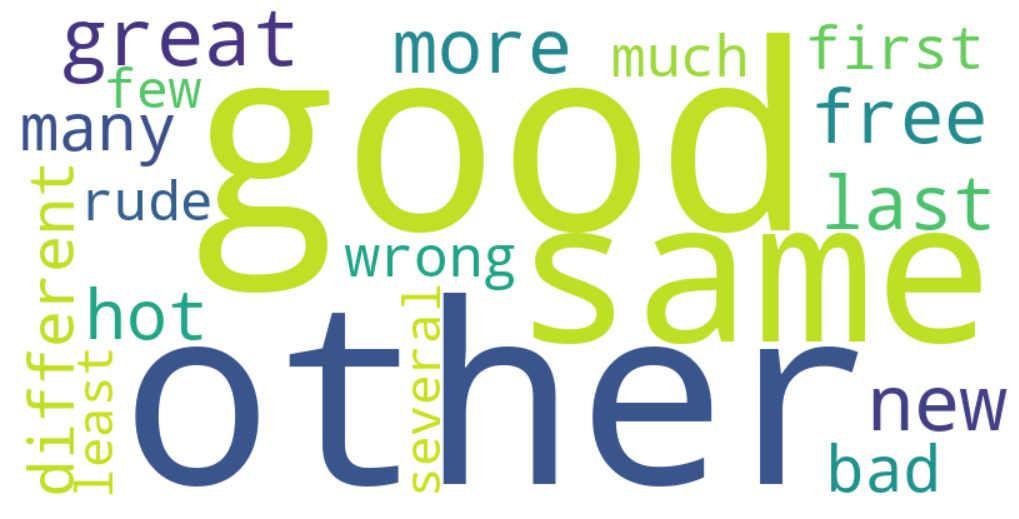

In [63]:
# 위에서 추출한 형용사와 그 빈도수를 딕셔너리로 변환합니다.
data = {
    'good': 97,
    'other': 91,
    'same': 80,
    'great': 77,
    'new': 72,
    'more': 68,
    'last': 65,
    'free': 64,
    'hot': 55,
    'many': 50,
    'bad': 48,
    'different': 47,
    'first': 46,
    'wrong': 43,
    'much': 43,
    'rude': 39,
    'few': 37,
    'several': 34,
    'least': 34
}

# 워드 클라우드 객체를 생성합니다.
wordcloud = WordCloud(width = 800, height = 400, background_color ='white')

# 빈도수를 기반으로 워드 클라우드를 생성합니다.
wordcloud.generate_from_frequencies(data)

# 생성된 워드 클라우드를 시각화합니다.
plt.figure(figsize = (10, 5), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0)

# 이미지를 PNG 파일로 저장합니다.
plt.savefig("wordcloud.png", format="png")

# 저장된 이미지 파일을 다운로드합니다 (Colab 환경에서 실행하는 경우)
from google.colab import files
files.download("wordcloud.png")

# 이미지를 저장하거나 보여줍니다.
plt.show()

##토픽을 나누는 2가지 방식

### 최적의 토픽 개수 찾기 : 3개
- Perplexity(혼란도)를 이용한 검증 데이터 활용
- LDA 모델을 훈련한 후, 훈련 데이터 이외의 새로운 데이터(검증 데이터)를 사용하여 perplexity를 측정
- Perplexity가 낮을수록 모델이 더 좋은 토픽을 학습

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0    [Amber, and, LaDonna, at, the, Starbucks, on, ...
1    [at, the, Starbucks, by, the, fire, station, o...
2    [I, just, wanted, to, go, out, of, my, way, to...
3    [Me, and, my, friend, were, at, Starbucks, and...
4    [I, 셫, on, this, kick, of, drinking, cups, of,...
Name: tokenized_reviews, dtype: object
Perplexity for 3 topics: 584.8820436688616
Perplexity for 4 topics: 598.9193539224285
Perplexity for 5 topics: 607.9316996998274
Perplexity for 6 topics: 627.6791535652882
Perplexity for 7 topics: 633.8762408667941
Perplexity for 8 topics: 639.1307058819033
Perplexity for 9 topics: 667.5089307440726
Perplexity for 10 topics: 678.098820780058


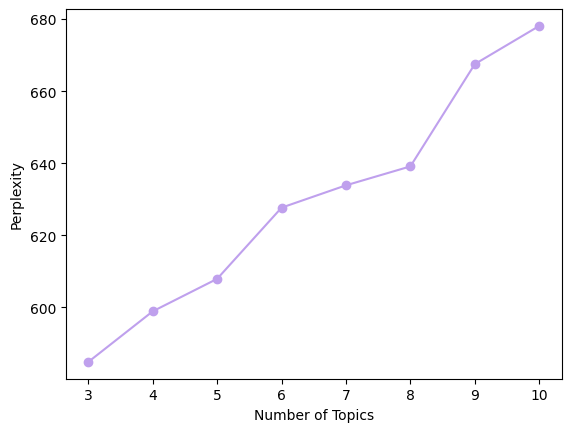

In [64]:
# 텍스트 토큰화
def tokenize_text(text):
    tokens = nltk.word_tokenize(text)
    return [word for word in tokens if word.isalpha()]

df['tokenized_reviews'] = df['Review'].apply(tokenize_text)

# 토큰화된 리뷰 확인
print(df['tokenized_reviews'].head())

# 토큰화된 리뷰를 다시 문서로 변환
documents = df['tokenized_reviews'].apply(lambda x: ' '.join(x))

# TF 벡터화
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)

# 여러 토픽 개수에 대해 perplexity 측정
num_topics_list = [3, 4, 5, 6, 7, 8, 9, 10]
perplexities = []

for num_topics in num_topics_list:
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=40)
    lda_model.fit(X)
    perplexities.append(lda_model.perplexity(X))
    print(f"Perplexity for {num_topics} topics: {lda_model.perplexity(X)}")

# 결과 시각화
plt.plot(num_topics_list, perplexities, marker='o', color='#BFA0ED')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.show()

### LDA 모델 _ TF-IDF 벡터화


In [65]:
# 텍스트 전처리: 소문자로 변환, 불용어 제거, 토큰화
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = nltk.word_tokenize(text.lower())
    words = [word for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(words)

df['processed_reviews'] = df['Review'].apply(preprocess_text)

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['processed_reviews'])

# LDA 모델 훈련
lda_model = LatentDirichletAllocation(n_components=3, random_state=42)
lda_topic_matrix = lda_model.fit_transform(X)

# 중요한 단어 추출 함수
def get_top_words_per_topic(topic_matrix, feature_names, n_words=30):
    top_words_per_topic = []
    for topic in topic_matrix:
        top_words_idx = topic.argsort()[-n_words:][::-1]
        top_words = [feature_names[idx] for idx in top_words_idx]
        top_words_per_topic.append(top_words)
    return top_words_per_topic

# 중요한 단어 추출
lda_feature_names = vectorizer.get_feature_names_out()
top_words_per_topic = get_top_words_per_topic(lda_model.components_, lda_feature_names)

# 정렬된 상대적인 빈도로 중요한 단어 출력
def print_sorted_word_frequencies(top_words_per_topic):
    for i, top_words in enumerate(top_words_per_topic):
        word_frequencies = [(word, top_words.index(word) + 1) for word in top_words]
        sorted_word_frequencies = sorted(word_frequencies, key=lambda x: x[1], reverse=True)

        print(f"Topic #{i+1} 단어 및 상대적인 빈도:")
        for word, frequency in sorted_word_frequencies:
            print(f"{word}: {frequency}")
        print()

print_sorted_word_frequencies(top_words_per_topic)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Topic #1 단어 및 상대적인 빈도:
usually: 30
store: 29
better: 28
free: 27
drink: 26
daily: 25
cheese: 24
drinks: 23
taste: 22
order: 21
locations: 20
make: 19
employees: 18
product: 17
prices: 16
every: 15
time: 14
sandwich: 13
food: 12
like: 11
get: 10
go: 9
quality: 8
customer: 7
great: 6
coffee: 5
good: 4
always: 3
service: 2
starbucks: 1

Topic #2 단어 및 상대적인 빈도:
gross: 30
airport: 29
coupon: 28
lemonade: 27
cold: 26
staff: 25
green: 24
muffins: 23
delicious: 22
tea: 21
press: 20
sweet: 19
ones: 18
feel: 17
love: 16
atmosphere: 15
services: 14
friendly: 13
professional: 12
efficient: 11
mug: 10
great: 9
enjoy: 8
foam: 7
nice: 6
music: 5
menu: 4
lunch: 3
selection: 2
chocolate: 1

Topic #3 단어 및 상대적인 빈도:
customers: 30
money: 29
day: 28
could: 27
never: 26
manager: 25
back: 24
told: 23
go: 22
cup: 21
got: 20
service: 19
like: 18
ordered: 17
asked: 16
went: 15
would: 14
order: 13
time: 12
customer: 11
get: 10
said: 9
card: 8
store: 7
drink: 6
one: 5
review: 4
text: 3
coffee: 2
starbucks: 1



### LDA 모델 _ TF 벡터화

In [66]:
# 텍스트 전처리: 소문자로 변환, 불용어 제거, 토큰화
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = nltk.word_tokenize(text.lower())
    words = [word for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(words)

df['processed_reviews'] = df['Review'].apply(preprocess_text)

# TF 벡터화
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['processed_reviews'])

# LDA 모델 훈련
lda_model = LatentDirichletAllocation(n_components=3, random_state=42)
lda_topic_matrix = lda_model.fit_transform(X)

# 중요한 단어 추출 함수
def get_top_words_per_topic(topic_matrix, feature_names, n_words=30):
    top_words_per_topic = []
    for topic in topic_matrix:
        top_words_idx = topic.argsort()[-n_words:][::-1]
        top_words = [feature_names[idx] for idx in top_words_idx]
        top_words_per_topic.append(top_words)
    return top_words_per_topic

# 중요한 단어 추출
lda_feature_names = vectorizer.get_feature_names_out()
top_words_per_topic = get_top_words_per_topic(lda_model.components_, lda_feature_names)

# 정렬된 상대적인 빈도로 중요한 단어 출력
def print_sorted_word_frequencies(top_words_per_topic):
    for i, top_words in enumerate(top_words_per_topic):
        word_frequencies = [(word, top_words.index(word) + 1) for word in top_words]
        sorted_word_frequencies = sorted(word_frequencies, key=lambda x: x[1], reverse=True)

        print(f"Topic #{i+1} 단어 및 상대적인 빈도:")
        for word, frequency in sorted_word_frequencies:
            print(f"{word}: {frequency}")
        print()

print_sorted_word_frequencies(top_words_per_topic)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Topic #1 단어 및 상대적인 빈도:
new: 30
make: 29
way: 28
times: 27
drinks: 26
stars: 25
free: 24
want: 23
drink: 22
people: 21
really: 20
going: 19
staff: 18
place: 17
order: 16
day: 15
location: 14
years: 13
great: 12
food: 11
good: 10
customers: 9
employees: 8
store: 7
time: 6
like: 5
service: 4
customer: 3
coffee: 2
starbucks: 1

Topic #2 단어 및 상대적인 빈도:
gave: 30
morning: 29
make: 28
minutes: 27
way: 26
barista: 25
took: 24
water: 23
ice: 22
line: 21
venti: 20
latte: 19
hot: 18
caramel: 17
told: 16
manager: 15
milk: 14
like: 13
got: 12
time: 11
store: 10
went: 9
asked: 8
cup: 7
order: 6
ordered: 5
said: 4
starbucks: 3
drink: 2
coffee: 1

Topic #3 단어 및 상대적인 빈도:
online: 30
time: 29
number: 28
credit: 27
cards: 26
phone: 25
day: 24
company: 23
purchase: 22
got: 21
text: 20
email: 19
use: 18
coffee: 17
received: 16
stores: 15
went: 14
manager: 13
review: 12
account: 11
gift: 10
money: 9
store: 8
said: 7
service: 6
called: 5
customer: 4
told: 3
card: 2
starbucks: 1



#6. 결론-감정을 나타내는 워드 클라우드, 토픽을 나타내는 워드 클라우드, 예측 엑셀, 모델의 정확도,시각화 자료

## 감정을 나타내는 워드 클라우드

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

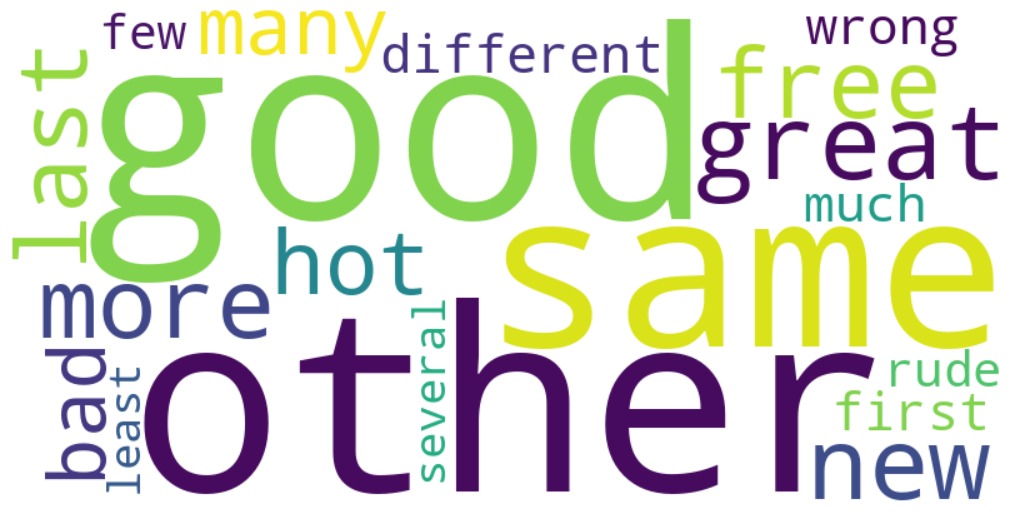

In [67]:
# 위에서 추출한 형용사와 그 빈도수를 딕셔너리로 변환합니다.
data = {
    'good': 97,
    'other': 91,
    'same': 80,
    'great': 77,
    'new': 72,
    'more': 68,
    'last': 65,
    'free': 64,
    'hot': 55,
    'many': 50,
    'bad': 48,
    'different': 47,
    'first': 46,
    'wrong': 43,
    'much': 43,
    'rude': 39,
    'few': 37,
    'several': 34,
    'least': 34
}

# 워드 클라우드 객체를 생성합니다.
wordcloud = WordCloud(width = 800, height = 400, background_color ='white')

# 빈도수를 기반으로 워드 클라우드를 생성합니다.
wordcloud.generate_from_frequencies(data)

# 생성된 워드 클라우드를 시각화합니다.
plt.figure(figsize = (10, 5), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0)

# 이미지를 PNG 파일로 저장합니다.
plt.savefig("wordcloud.png", format="png")

# 저장된 이미지 파일을 다운로드합니다 (Colab 환경에서 실행하는 경우)
from google.colab import files
files.download("wordcloud.png")

# 이미지를 저장하거나 보여줍니다.
plt.show()

## 토픽을 나타내는 워드 클라우드

### **토픽 3개**
### LDA 모델 _ TF-IDF 벡터화
- **Topic#1 사람에 대한 평가** : great, even, told, people/ customers, employees 등
- **Topic#2 커피 종류, 사이즈** : size, shots, gave/ cream, milk, cake, frappuccino, white, chocolate, mocha 등
- **Topic#3 가격, 결제** : purchase, strong, paypal, steel/ password, app, discount, reload 등

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



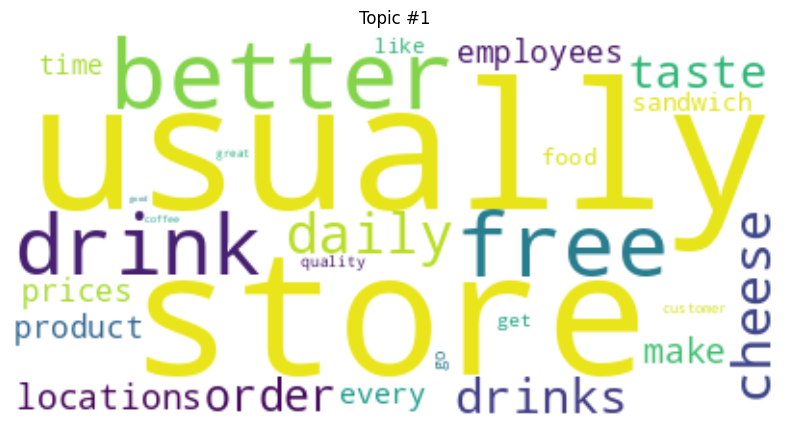

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



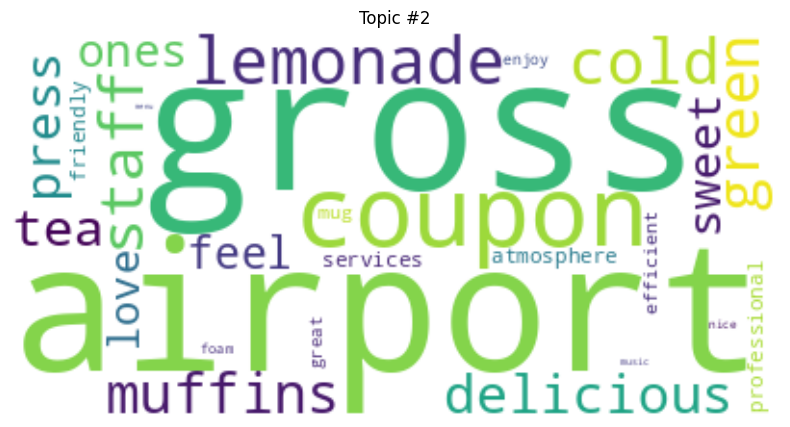

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



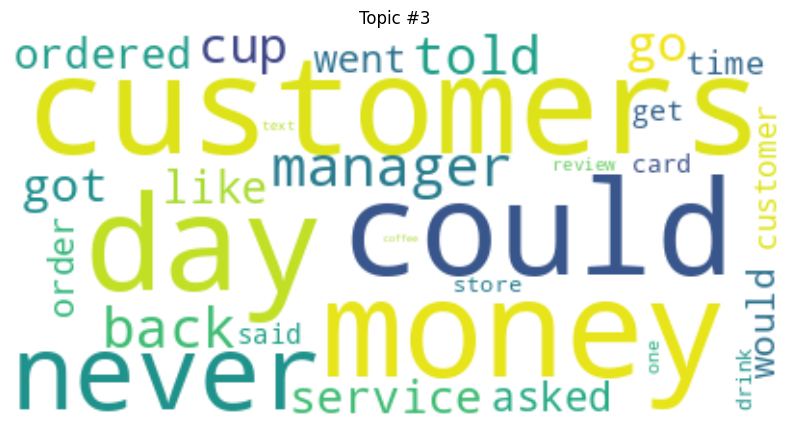

In [68]:
# 텍스트 전처리: 소문자로 변환, 불용어 제거, 토큰화
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = nltk.word_tokenize(text.lower())
    words = [word for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(words)

df['processed_reviews'] = df['Review'].apply(preprocess_text)

# TF-IDF 벡터화
vectorizer_1 = TfidfVectorizer(max_features=1000)
X_1 = vectorizer_1.fit_transform(df['processed_reviews'])

# LDA 모델 훈련
lda_model_1 = LatentDirichletAllocation(n_components=3, random_state=42)
lda_topic_matrix = lda_model_1.fit_transform(X_1)

# 중요한 단어 추출 함수
def get_top_words_per_topic(topic_matrix, feature_names, n_words=30):
    top_words_per_topic = []
    for topic in topic_matrix:
        top_words_idx = topic.argsort()[-n_words:][::-1]
        top_words = [feature_names[idx] for idx in top_words_idx]
        top_words_per_topic.append(top_words)
    return top_words_per_topic

# 중요한 단어 추출
lda_feature_names = vectorizer_1.get_feature_names_out()
top_words_per_topic = get_top_words_per_topic(lda_model_1.components_, lda_feature_names)

# 워드클라우드 생성 및 시각화
def visualize_wordcloud(top_words_per_topic, model_name):
    for i, top_words in enumerate(top_words_per_topic):
        wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(dict(zip(top_words, range(len(top_words)))))
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Topic #{i+1}")
        plt.show()

# 중요한 단어 워드클라우드
visualize_wordcloud(top_words_per_topic, "LDA")

### LDA 모델 _ TF 벡터화
- **Topic#1 사람** : lady, people, counter, customers, employee, barista, service 등
- **Topic#2 주문 + 음료** : hot, people, drinks, work, home, ordered, cream, really, customer, employees 등
- **Topic#3 구매 당시 정보** : rewards, new, days, great, location, times, account, email, company 등

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



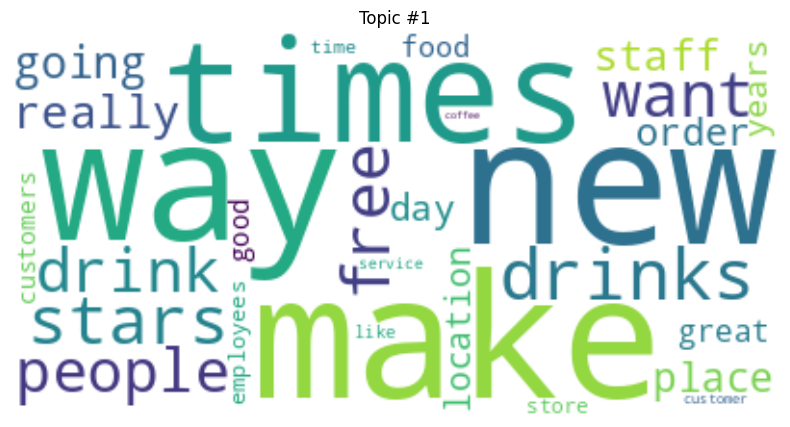

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



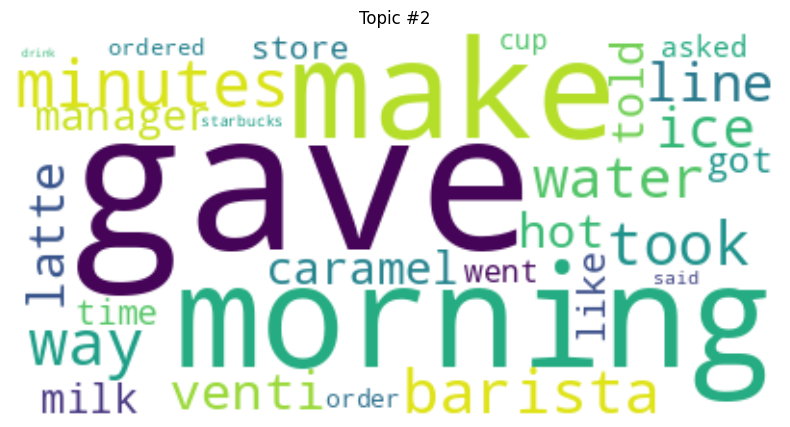

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



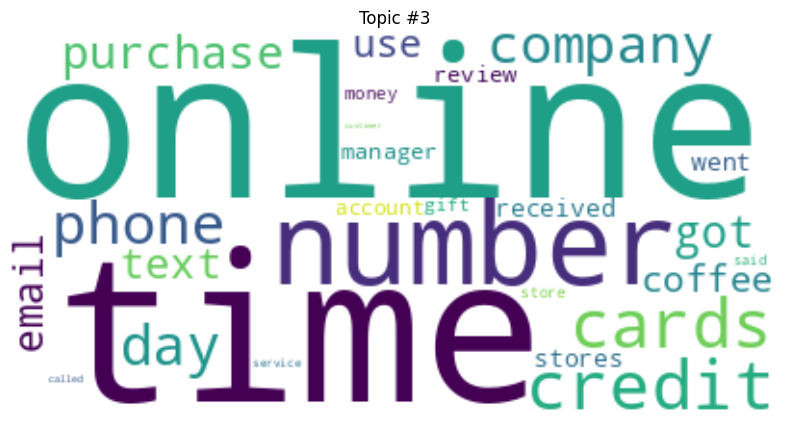

In [69]:
# 텍스트 전처리: 소문자로 변환, 불용어 제거, 토큰화
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = nltk.word_tokenize(text.lower())
    words = [word for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(words)

df['processed_reviews'] = df['Review'].apply(preprocess_text)

# TF 벡터화
vectorizer_2 = CountVectorizer(max_features=1000, stop_words='english')
X_2 = vectorizer_2.fit_transform(df['processed_reviews'])

# LDA 모델 훈련
lda_model_2 = LatentDirichletAllocation(n_components=3, random_state=42)
lda_topic_matrix = lda_model_2.fit_transform(X_2)

# 중요한 단어 추출 함수
def get_top_words_per_topic(topic_matrix, feature_names, n_words=30):
    top_words_per_topic = []
    for topic in topic_matrix:
        top_words_idx = topic.argsort()[-n_words:][::-1]
        top_words = [feature_names[idx] for idx in top_words_idx]
        top_words_per_topic.append(top_words)
    return top_words_per_topic

# 중요한 단어 추출
lda_feature_names = vectorizer_2.get_feature_names_out()
top_words_per_topic = get_top_words_per_topic(lda_model_2.components_, lda_feature_names)

# 워드클라우드 생성 및 시각화
def visualize_wordcloud(top_words_per_topic, model_name):
    for i, top_words in enumerate(top_words_per_topic):
        wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(dict(zip(top_words, range(len(top_words)))))
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Topic #{i+1}")
        plt.show()

# 중요한 단어 워드클라우드
visualize_wordcloud(top_words_per_topic, "LDA")

## 예측 엑셀

In [70]:
# 결과를 Excel 파일로 저장합니다.
df_predicted_ratings[['Review', 'Rating']].to_excel('predicted_ratings.xlsx', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## 모델의 정확도

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       116
           1       0.71      0.48      0.57        25

    accuracy                           0.87       141
   macro avg       0.80      0.72      0.75       141
weighted avg       0.86      0.87      0.86       141

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       116
           1       0.75      0.36      0.49        25

    accuracy                           0.87       141
   macro avg       0.81      0.67      0.70       141
weighted avg       0.85      0.87      0.85       141

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.99      0.91       116
           1       0.67      0.08      0.14        25

    accuracy                           0.83       141
   macro avg       0.75      0.54      0.52       141
weighted avg       0.80      0.83      0.77       141

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       116
           1       0.87      0.52      0.65        25

    accuracy                           0.90       141
   macro avg       0.89      0.75      0.80       141
weighted avg       0.90      0.90      0.89       141

LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       116
           1       0.76      0.52      0.62        25

    accuracy                           0.89       141
   macro avg       0.83      0.74      0.78       141
weighted avg       0.88      0.89      0.88       141

AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       116
           1       0.80      0.48      0.60        25

    accuracy                           0.89       141
   macro avg       0.85      0.73      0.77       141
weighted avg       0.88      0.89      0.87       141

## 시각화 자료

### LDA 모델 _ TF-IDF 벡터화 시각화

In [71]:
topic_term_dists = lda_model_1.components_ / lda_model_1.components_.sum(axis=1)[:, None]
doc_topic_dists = lda_model_1.transform(X_1)
doc_lengths = [doc.getnnz() for doc in X_1]  # Modify this line
vocab = vectorizer_1.get_feature_names_out()
term_frequency = np.sum(X_1, axis=0).tolist()[0]

vis = pyLDAvis.prepare(
    topic_term_dists=topic_term_dists,
    doc_topic_dists=doc_topic_dists,
    doc_lengths=doc_lengths,
    vocab=vocab,
    term_frequency=term_frequency
)
pyLDAvis.display(vis)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### LDA 모델 _ TF 벡터화 시각화

In [72]:
topic_term_dists = lda_model_2.components_ / lda_model_2.components_.sum(axis=1)[:, None]
doc_topic_dists = lda_model_2.transform(X_2)
doc_lengths = [doc.getnnz() for doc in X_2]  # Modify this line
vocab = vectorizer_2.get_feature_names_out()
term_frequency = np.sum(X_2, axis=0).tolist()[0]

vis = pyLDAvis.prepare(
    topic_term_dists=topic_term_dists,
    doc_topic_dists=doc_topic_dists,
    doc_lengths=doc_lengths,
    vocab=vocab,
    term_frequency=term_frequency
)
pyLDAvis.display(vis)




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

